In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/faults_pr3/

/content/gdrive/MyDrive/faults_pr3


Loading data-----------------
[1588 1028 1812 ...  730  128 3123]
______Training process_____
Epoch: [1 | 100] LR: 0.001000 Train:Loss_Avg=0.043381 Accuracy_Avg=23.922414 Valid: Loss=0.043355 Accuracy=24.324324 Time: 6.805243
Epoch: [2 | 100] LR: 0.001000 Train:Loss_Avg=0.042393 Accuracy_Avg=27.837644 Valid: Loss=0.051059 Accuracy=26.520270 Time: 6.693677
Epoch: [3 | 100] LR: 0.001000 Train:Loss_Avg=0.040143 Accuracy_Avg=33.728448 Valid: Loss=0.026865 Accuracy=47.888514 Time: 6.779301
Epoch: [4 | 100] LR: 0.001000 Train:Loss_Avg=0.026685 Accuracy_Avg=48.275862 Valid: Loss=0.026267 Accuracy=48.395270 Time: 6.806375
Epoch: [5 | 100] LR: 0.001000 Train:Loss_Avg=0.025946 Accuracy_Avg=49.533046 Valid: Loss=0.026117 Accuracy=48.564189 Time: 6.818413
Epoch: [6 | 100] LR: 0.001000 Train:Loss_Avg=0.025882 Accuracy_Avg=50.107759 Valid: Loss=0.026150 Accuracy=50.000000 Time: 6.837391
Epoch: [7 | 100] LR: 0.001000 Train:Loss_Avg=0.026463 Accuracy_Avg=48.096264 Valid: Loss=0.026257 Accuracy=48.6486

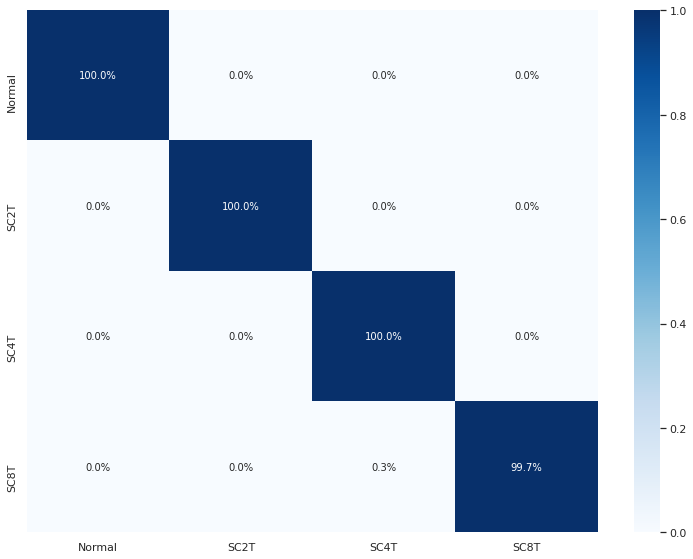

-----------------------------------------
---------------------TESTING--------------------
Test Accuracy: 99.916 %
Acc : 99.91554054054055
1.0000	1.0000	0.9967	1.0000
1.0000	1.0000	1.0000	0.9966
1.0000	1.0000	0.9983	0.9983
Average P/R/F: 0.9992	0.9991	0.9992
[[287   0   0   0]
 [  0 308   0   0]
 [  0   0 299   0]
 [  0   0   1 289]]


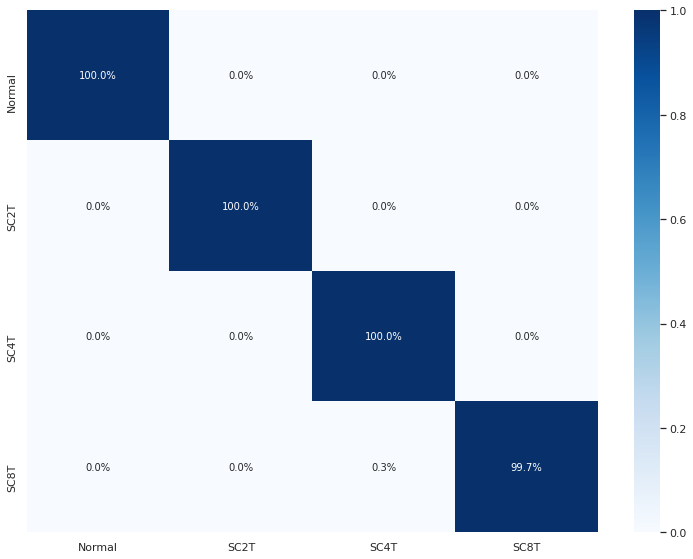

---------------------FINISH--------------------


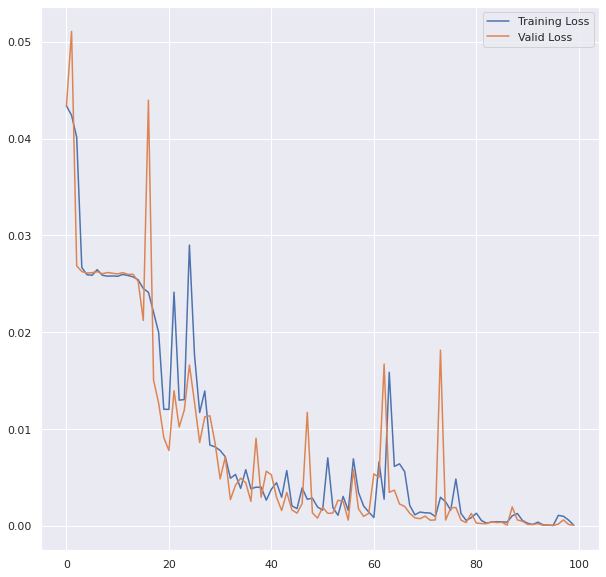

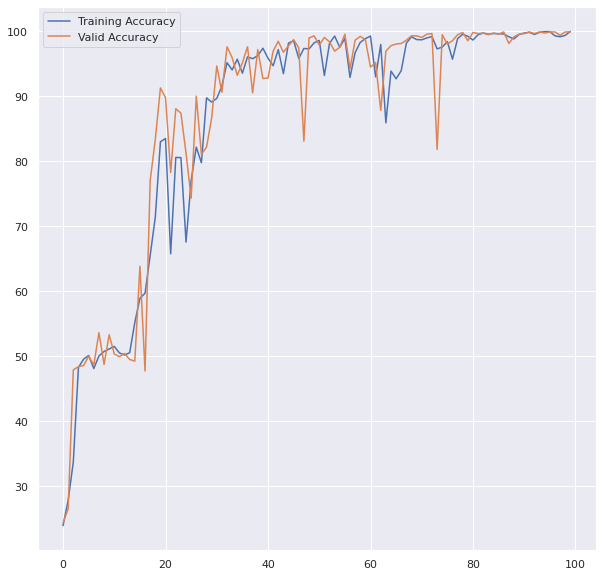

In [ ]:
import numpy as np
import torch
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import sklearn as sk
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from glob import glob
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
%matplotlib inline
learning_rate=0.001

class CNN_LSTM(nn.Module):
    
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(0.5) 
        self.conv1=nn.Conv1d(in_channels=1, out_channels=64, kernel_size=([50,1]),stride=1,padding=0)
        self.conv2=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.conv3=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.conv4=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, num_layers=2)
#         self.fc3=nn.Linear(in_features=256, out_features=256)
        self.fc=nn.Linear(in_features=128, out_features=4)
    
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.relu(x)
        x=self.conv4(x)
        x=self.relu(x)
        x=x.permute(2,0,1,3).contiguous()
        # x = x.view(84,-1,64)
        x = x.view(888, -1, 64)
        x,_ = self.lstm1(x)
#         x = x.contiguous().view(-1, 128)
        x = self.dropout(x)
        x=x[-1]
#         x=self.fc3(x)
        x=self.fc(x)
        x = x.view(32, -1, 4)[:,-1,:]
        return x

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def load_data(path_x, path_y):
  # train_x = np.empty((0, 1024, 1, 1))
  # train_y = np.empty((0))
  # valid_x = np.empty((0, 1024, 1, 1))
  # valid_y = np.empty((0))
  # test_x = np.empty((0, 1024, 1, 1))
  # test_y = np.empty((0))

  print('Loading data-----------------')
  X_in = np.load(path_x)
  X_in = X_in.reshape(3999, 1024, 1)

  Y_in = np.load(path_y)
  Y_in = Y_in.reshape(3999)

  shuffle_idx = np.random.permutation(Y_in.shape[0])
  print(shuffle_idx)
  x = X_in[shuffle_idx]
  y = Y_in[shuffle_idx]

  train_x = x[0: int(y.shape[0]*0.7)]
  train_x = train_x.reshape(-1, 1, 1024, 1)
  train_x = np.transpose(train_x, axes= [0,3,2,1])
  train_x = torch.from_numpy(train_x).float()

  train_y = y[0: int(y.shape[0]*0.7)]
  train_y = torch.from_numpy(train_y).long()

  valid_x = x[int(y.shape[0]*0.7):]
  valid_x = valid_x.reshape(-1, 1, 1024, 1)
  valid_x = np.transpose(valid_x, axes= [0,3,2,1])
  valid_x = torch.from_numpy(valid_x).float()

  valid_y = y[int(y.shape[0]*0.7):]
  valid_y = torch.from_numpy(valid_y).long()

  test_x = x[int(y.shape[0]*0.7):]
  test_x = test_x.reshape(-1, 1, 1024, 1)
  test_x = np.transpose(test_x, axes= [0,3,2,1])
  test_x = torch.from_numpy(test_x).float()

  test_y = y[int(y.shape[0]*0.7):]
  test_y = torch.from_numpy(test_y).long()

  # train_y = torch.max(train_y, 0)[1]
  # valid_y = torch.max(valid_y, 0)[1]
  # test_y = torch.max(test_y, 0)[1]
  
  return train_x, train_y, test_x, test_y, valid_x, valid_y

def train(train_x, train_y, model, criterion, optimizer, epoch):
  model.train()
  total_loss = 0
  total_correct = 0
  total_input = 0
  iterations = 0
  for batch_x, batch_y in iterate_minibatches(train_x, train_y, batchsize=32):
    inputs = batch_x
    labels = batch_y

    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, predicted =  torch.max(outputs, 1)
    correct = (predicted == labels).sum()

    total_loss += loss.item()
    total_correct += correct.item()
    total_input += inputs.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iterations += 1
  
  loss = total_loss/total_input
  accuracy = (100 * total_correct/total_input)
  path = '/content/gdrive/MyDrive/faults_pr3/models/LSTM/stator_faults_{}.pth'.format(epoch)
  torch.save({'state_dict' : model.state_dict()}, path)
  return loss, accuracy

def valid(valid_x,valid_y,model,criterion):
    model.eval()
    total_loss=0
    total_correct=0
    total_input=0
    iterations=0
    y_true, y_pred = [], []
    for batch_x,batch_y in iterate_minibatches(valid_x, valid_y, batchsize=32):
        inputs = batch_x
        labels = batch_y
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct=(predicted == labels).sum()
        y_true.append(labels)
        y_pred.append(predicted)
        total_loss+=loss.item()
        total_correct+=correct.item()
        total_input+=inputs.size(0)
        iterations+=1

    loss=total_loss/total_input
    accuracy=(100*total_correct/total_input)
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).data.cpu().numpy()
    return loss,accuracy, y_true, y_pred

def test(model,test_x,test_y):
    model.eval()  
    with torch.no_grad():
        total_correct = 0
        total_input=0
        y_true, y_pred = [], []
        for batch_x,batch_y in iterate_minibatches(test_x, test_y, batchsize=32):
            inputs = batch_x
            labels = batch_y

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct=(predicted == labels).sum()
            y_true.append(labels)
            y_pred.append(predicted)
            total_correct+=correct.item()
            total_input+=inputs.size(0)
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).data.cpu().numpy()

    accuracy=(100*total_correct/total_input)
    return accuracy , y_true, y_pred

def print_results(best,best_y_true,best_y_pred):
    p = precision_score(best_y_true, best_y_pred, average=None)
    r = recall_score(best_y_true, best_y_pred, average=None)
    f = f1_score(best_y_true, best_y_pred, average=None)
    cm = confusion_matrix(best_y_true, best_y_pred)

    print('Acc : {}'.format(best))
    print('\t'.join(['%0.4f'%(x) for x in p]))
    print('\t'.join(['%0.4f'%(x) for x in r]))
    print('\t'.join(['%0.4f'%(x) for x in f]))

    print('Average P/R/F: %0.4f\t%0.4f\t%0.4f'%(np.mean(p),np.mean(r),np.mean(f)))
    print(cm)
    return p,r,f
  
def plot_confusion_matrix(y_test, y_pred, labels):    
    fig = plt.figure(figsize=(12.8, 9.6))
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'), columns=labels, index=labels)
    sn.set(font_scale=1)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},fmt='.1%' ,cmap='Blues')
    plt.show()

def main():
    num_epochs=100
    num_channels = 1
    train_x,train_y,valid_x,valid_y,test_x,test_y=load_data(path_x = 'dataset/X.npy', path_y = 'dataset/Y.npy')
    model=CNN_LSTM()

    CUDA = torch.cuda.is_available()
    if CUDA:
        model = model.cuda()  
    print("______Training process_____")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     optimizer = optim.RMSprop(model.parameters(), lr=1e-3, alpha = 0.9)
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99)

    train_loss=[]
    train_accuracy=[]
    valid_loss=[]
    valid_accuracy=[]
    test_acc = []
    precision = []
    f1 = []
    recall = []
    best_at = 0
    best = 0.0
    best_y_true = None
    best_y_pred = None
    for epoch in range(num_epochs): 
        start = time.time()

        loss_avg,accuracy_avg = train(train_x,train_y,model,criterion,optimizer,epoch)
        valid_loss_avg,valid_acc_avg, y_true, y_pred =valid(valid_x,valid_y,model,criterion)

        train_loss.append(loss_avg)      
        train_accuracy.append(accuracy_avg)
        valid_loss.append(valid_loss_avg)      
        valid_accuracy.append(valid_acc_avg)
        stop = time.time()
        print('Epoch: [%d | %d] LR: %f Train:Loss_Avg=%f Accuracy_Avg=%f Valid: Loss=%f Accuracy=%f Time: %f' 
        % (epoch + 1, num_epochs, learning_rate,loss_avg,accuracy_avg,valid_loss_avg,valid_acc_avg, stop-start))

        if best < valid_acc_avg:
            best_at = epoch
            best = valid_acc_avg
            best_y_true = y_true
            best_y_pred = y_pred
    print('-----------------------------------------')

    print('Best at %d : %f' % (best_at, best))
    p,r,f = print_results(best, best_y_true, best_y_pred)
    cm = plot_confusion_matrix(best_y_true, best_y_pred, ['Normal', 'SC2T', 'SC4T', 'SC8T'])
    
    print('-----------------------------------------')

    print('---------------------TESTING--------------------')

    test_accuracy, y_true, y_pred = test(model,test_x,test_y)
    print('Test Accuracy: {:.3f} %'.format(test_accuracy))
    p,r,f = print_results(test_accuracy, y_true, y_pred)
    cm = plot_confusion_matrix(y_true, y_pred, ['Normal', 'SC2T', 'SC4T', 'SC8T'])
    
    precision.append(p)
    f1.append(f)
    recall.append(r)
    test_acc.append(test_accuracy)
    print('---------------------FINISH--------------------')

    # Loss
    f = plt.figure(figsize=(10, 10))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Valid Loss')
    plt.legend()
    plt.show()

    # Accuracy
    f = plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Valid Accuracy')
    plt.legend()
    plt.show()

    train_loss=np.asarray(train_loss)
    train_accuracy=np.asarray(train_accuracy)
    valid_loss=np.asarray(valid_loss)
    valid_accuracy=np.asarray(valid_accuracy)
    np.save('train_loss',train_loss)
    np.save('train_accuracy',train_accuracy)
    np.save('valid_loss',valid_loss)
    np.save('valid_accuracy',valid_accuracy)

    test_acc = np.asarray(test_acc)
    precision = np.asarray(precision)
    f1 = np.asarray(f1)
    recall = np.asarray(recall)
    np.save('test_acc',test_acc)
    np.save('precision',precision)
    np.save('f1',f1)
    np.save('recall',recall)
if __name__ == '__main__':
    main()

In [ ]:
import numpy as np
import pandas as pd
import torch

X_in = np.load('dataset/X.npy')
X_in = X_in.reshape(3999, 1024, 1)

Y_in = np.load('dataset/Y.npy')
Y_in = Y_in.reshape(3999)

shuffle_idx = np.random.permutation(Y_in.shape[0])
print(shuffle_idx)
x = X_in[shuffle_idx]
y = Y_in[shuffle_idx]

train_x = x[0: int(y.shape[0]*0.70)]
train_x = train_x.reshape(-1, 1, 1024, 1)
train_x = np.transpose(train_x, axes= [0,3,2,1])
train_x = torch.from_numpy(train_x).float()

train_y = y[0: int(y.shape[0]*0.70)]
train_y = torch.from_numpy(train_y).long()

valid_x = x[int(y.shape[0]*0.76):]
valid_x = valid_x.reshape(-1, 1, 1024, 1)
valid_x = np.transpose(valid_x, axes= [0,3,2,1])
valid_x = torch.from_numpy(valid_x).float()

valid_y = y[int(y.shape[0]*0.8):]
valid_y = torch.from_numpy(valid_y).long()

test_x = x[int(y.shape[0]*0.8):]
test_x = test_x.reshape(-1, 1, 1024, 1)
test_x = np.transpose(test_x, axes= [0,3,2,1])
test_x = torch.from_numpy(test_x).float()

test_y = y[int(y.shape[0]*0.8):]
test_y = torch.from_numpy(test_y).long()

# print(train_y)
# a = torch.max(train_y, 1)[1]
# print(a)
# print(test_y.shape)
print(len(train_x))
print(len(train_y))
print(train_x.size())



[2996 3038 2625 ... 2076 1668 2399]
2799
2799
torch.Size([2799, 1, 1024, 1])


Feature-TSNE

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(0.5) 
        self.conv1=nn.Conv1d(in_channels=1, out_channels=64, kernel_size=[50,1],stride=1,padding=0)
        self.conv2=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.conv3=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.conv4=nn.Conv1d(in_channels=64, out_channels=64, kernel_size=[30,1],stride=1,padding=0)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1)
        self.fc=nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.relu(x)
        x=self.conv4(x)
        x=self.relu(x)
        x=x.permute(2,0,1,3).contiguous()
        x = x.view(888,-1,64)
        x,_ = self.lstm1(x)
        x,_ = self.lstm2(x)
#         x = x.contiguous().view(-1, 128)
        x = self.dropout(x)
        x=x[-1]
        return x
        x=self.fc(x)
        x = x.view(1, -1, 4)[:,-1,:]
        print(x.shape)
        return x

def main():
  x = np.load('dataset/X.npy')
  y = np.load('dataset/Y.npy')
  shuffle_idx = np.random.permutation(y.shape[0])
  print(shuffle_idx)
  x = x[shuffle_idx]
  y = y[shuffle_idx]

  train_x = x[0 : int(y.shape[0]*0.7)]
  train_y=y[0 : int(y.shape[0]*0.7)]

  valid_x=x[int(y.shape[0]*0.7):]
  valid_y=y[int(y.shape[0]*0.7):]

  test_x=x[int(y.shape[0]*0.7):]
  test_y=y[int(y.shape[0]*0.7):]
  # test_y=np.asarray(pd.get_dummies(test_y), dtype = np.int8)
  test_y=torch.from_numpy(test_y).long()
  # test_y=torch.max(test_y, 1)[1]
  test_y = test_y.numpy()
  np.save('feature/y_LSTM_feature.npy', test_y)
  print(test_x.shape)
  print(x.shape)
  X = test_x.reshape(-1, 1, 1024, 1)
  print(X.shape)
  model = CNN_LSTM()
  print('-' * 10 + 'Loading model from checkpoint' + '-' *10)
  checkpoint = torch.load('models/LSTM/stator_faults_86.pth')
  model.load_state_dict(checkpoint['state_dict'], strict = False)
  print(model)
  model.eval()
  with torch.no_grad():
        feature_array = np.empty((0,128))
        for i,x in enumerate(X):
            x = torch.from_numpy(x.reshape(-1,1,1024,1)).float()
            feature = model(x)
            feature = (feature.numpy()).reshape(-1)
            feature_array = np.vstack((feature_array, feature))
#             print(feature_array.shape)
        np.save('feature/X_LSTM_feature.npy', feature_array)
        print('Done')
        print(feature_array.shape)
if __name__ == '__main__':
  main()


[1943 1058  608 ... 2106  786 1046]
(1200, 1024)
(3999, 1024)
(1200, 1, 1024, 1)
----------Loading model from checkpoint----------
CNN_LSTM(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 64, kernel_size=(50, 1), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(30, 1), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(30, 1), stride=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(30, 1), stride=(1,))
  (lstm1): LSTM(64, 128)
  (lstm2): LSTM(128, 128)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)
Done
(1200, 128)


In [ ]:
lstm_features = np.load('feature/X_LSTM_feature.npy')
lstm_labels = np.load('feature/y_LSTM_feature.npy')
classes = ['Normal', 'SC2T', 'SC4T', 'SC8T']
lstm_labels = [classes[int(i)] for i in lstm_labels]

In [ ]:
import seaborn as sns
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

<Figure size 432x288 with 0 Axes>

In [ ]:
import pandas as pd

import seaborn as sns

def visualize(features, labels, name):
    # flatui = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    #         "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    #         "#5A0007", "#809693", "#FEFFE6"]
    flatui = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF"]
    sns.set(style="white")
    data = pd.DataFrame(features, columns=['D1', 'D2'])
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
    g = sns.relplot(x='D1', y='D2', hue=labels, alpha=.5, palette=sns.color_palette(flatui),
                height=10, data=data).set(title = 'Feature extracted from ' + name)
    g.despine(left=True, bottom=True)
    plt.axis('off')
    plt.show()

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
%matplotlib inline

X_embedded_lstm = TSNE(n_components=2).fit_transform(lstm_features)

<Figure size 432x288 with 0 Axes>

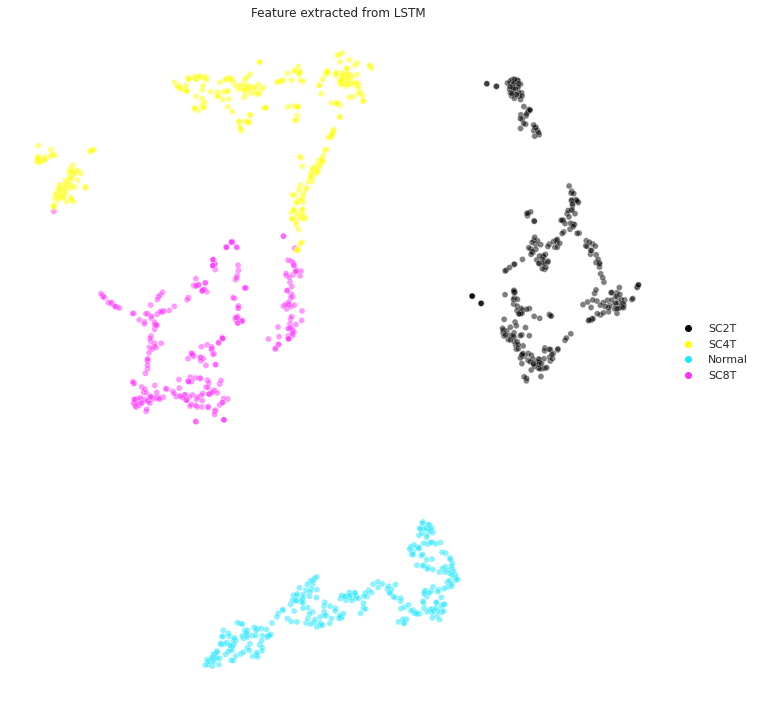

In [ ]:
visualize(X_embedded_lstm, lstm_labels, 'LSTM')